In [1]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

functions

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_diff(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def mean_squared_error(y,t):
    # return np.sum((y-t)**2) / len(y)
    return np.sum((y-t)**2)

- 성능 최적화, 배치 처리, 나중에 계산을 위해 MSE를 단순화함

Layers

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None # 순전파의 출력 값을 저장할 변

    def forward(self,x):
        out = sigmoid(x)
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * self.out * (1.0 - self.out) # 미분 계산
        # dout = Loss를 예측치(y)에 대해 미분한 값
        
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W # 가중치 행렬
        self.b = b # 편향(바이어스(b) 벡터)

        self.original_x_shape = None # 입력 데이터의 원래 형태를 저장
        self.x = None # 입력 데이터를 저장 (역전파에 필요)

        # 가중치, 편향에 대한 기울기 계산(역전파에서 계산)
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape # 입력 데이터의 원래 형태 저장
        x = x.reshape(x.shape[0],-1) # 입력 데이터를 2차원 형태로 변환
        self.x = x # 변환된 입력 데이터를 저장

        out = np.dot(self. x, self.W) + self.b # x에 가중치(내적)와 편향을 적용 out = X*W + b
        return out

    def backward(self, dout):
        dx = np.dot(dout,self.W.T) # 입력값 x에 대한 기울기 계산
        # why? 은닉층이 여러 개일 경우 입력값이 이전 층에서 역전파를 전달받기 위한 매개체 역할
        # 은닉층이 하나일때는 고려하지 않음.

        # 가중치, 편향에 대한 기울기 계산(역전파에서 계산)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape) # 입력값의 원래 모양 복원원
        return dx

class MeanSquaredError:
    def __init__(self):
        self.y = None # 순전파 예측값 저장
        self.t = None # 순전파의 타겟(정답) 저장
        self.loss = None # 계산된 손실 값 저장

    def forward(self, x, t):
        self.y = x # 예측값 저장
        self.t = t # 타겟값 저장
        self.loss = 0.5 * mean_squared_error(self.y, self.t) / self.y.shape[0] # MSE계산, 1/2곱으로 간단히 표기
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0] # 배치 크기
        dx = (self.y - self.t) / batch_size # MSE의 미분(순간변화율) 계산
        return dx
        

은닉층이 1개(선형 - 비선형 - 출력)인 신경망 구현

In [11]:
class Neural_Network:
    # 입력 노드 개수, 은닉층 노드 개수, 출력 노드 개수를 매개변수로 받음.
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}

        # 첫 번째 층의 가중치, 편향 초기화
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        # 두 번째 층의 가중치, 편향 초기화
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 연결 정보를 저장하는 키 생성 (ex. w_ij 형태)
        # self.connection_keys = {
        #     "W1": [(f"w{i}_{j}") for i in range(1, input_size + 1) for j in range(1, hidden_size + 1)],
        #     "b1": [(f"b{i}") for i in range(1, hidden_size + 1)],
        #     "W2": [(f"w{i}_{j}") for i in range(1, hidden_size + 1) for j in range(1, output_size + 1)],
        #     "b2": [(f"b{i}") for i in range(1, output_size + 1)]
        # }

        # --------------------------------------
        
        self.connection_keys = {
            "W1": [f"w{i}_{j}" for i in range(1, self.params['W1'].shape[0] + 1) for j in range(1, self.params['W1'].shape[1] + 1)],
            "b1": [f"b{j}" for j in range(1, self.params['b1'].shape[0] + 1)],
            "W2": [f"w{i}_{j}" for i in range(1, self.params['W2'].shape[0] + 1) for j in range(1, self.params['W2'].shape[1] + 1)],
            "b2": [f"b{j}" for j in range(1, self.params['b2'].shape[0] + 1)]
        }
        # --------------------------------------
        

        self.layers = OrderedDict() # 순전파 시 각 레이어를 순서대로 실행하도록 구성
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1']) # 첫 번째 Affine layer
        self.layers['Sigmoid'] = Sigmoid() # Activation function 적용
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2']) # 두 번째 Affine layer
        self.last_layer = MeanSquaredError() # Loss 계산

    def predict(self, x): # 입력값 x를 받아 순전파 실행
        for layer in self.layers.values(): # 각 layer의 forward 메서드 호출해 순차적으로 처리
            x = layer.forward(x)

        return x

    def loss(self, x,t): # 입력값 x와 타겟 t를 받아 loss 계산
        y = self.predict(x) # y(출력값) 계산

        return self.last_layer.forward(y,t) # 마지막 레이어에서 loss 계산

    def accuracy(self, x,t):
        y = self.predict(x)
        
        # 모델 출력값(y)를 0.5 기준으로 이진 분류
        idx1 = np.where(y>0.5)
        idx2 = np.where(y<=0.5)
        y[idx1] = 1
        y[idx2] = 0
        
        # 정확도 반환
        acc = np.sum(y==t) / len(t)
        return acc

    def gradient(self, x, t): # 입력값 x_data, 타겟값 y_data를 이용해 역전파, 각 레이어의 순간변화율 계
        self.loss(x,t)
        dout = 1 # 초기화
        dout = self.last_layer.backward(dout) # 출력값 y에 대해 Loss 기울기 계산

        # 각 layer의 역전파 메서드를 역순으로 호출, 미분 계산
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 각 layer의 미분값을 딕셔너리로 반환
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [11]:
X_data = np.array([[1, 1],
                  [1, 0],
                  [0, 1],
                  [0, 0]])
y_data = np.array([[0],
                  [1],
                  [1],
                  [0]])
print(X_data)
print(y_data)

[[1 1]
 [1 0]
 [0 1]
 [0 0]]
[[0]
 [1]
 [1]
 [0]]


신경망 선언

## 각 은닉층의 노드 수 1개

In [15]:
network = Neural_Network(input_size=2,hidden_size=1,output_size=1)

print("초기화된 신경망의 파라미터값 :")
print(network.params)

print("\n가중치 연결 정보")
print(network.connection_keys)

초기화된 신경망의 파라미터값 :
{'W1': array([[-0.40059812],
       [-0.80306317]]), 'b1': array([0.]), 'W2': array([[-0.20317376]]), 'b2': array([0.])}

가중치 연결 정보
{'W1': ['w1_1', 'w2_1'], 'b1': ['b1'], 'W2': ['w1_1'], 'b2': ['b1']}


### 학습

In [274]:
lr = 0.1
epoch = 10001

for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)
    
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # # ex. key = w_1_1, w_1_2 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출

            # --------------------------------------
            
            # 'w1_100' → '1', '100' 추출
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
                 
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
        
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue
            # --------------------------------------
            
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1:]) - 1 # 'b100'에서 100 추출
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]
 
    if i % (epoch//10) == 0:
        print("=============================================================")
        print("\n{}th 업데이트".format(i))
        
        acc = network.accuracy(X_data, y_data)
        print("정확도 : ", acc)
        
        loss = network.loss(X_data, y_data)
        print("손실함수값 : ", loss)
        print("예측 : : \n", np.round(network.predict(X_data), 2))
        
        print("\n파라미터값 : \n", network.params)
        
        print("\n손실함수에 대한 각 파라미터의 미분값 : \n", grad)
        print("\n\n")


0th 업데이트
정확도 :  0.5
손실함수값 :  0.19873933944642108
예측 : : 
 [[0.98]
 [0.53]
 [1.05]
 [0.63]]

파라미터값 : 
 {'W1': array([[-0.30550996],
       [ 1.45121542]]), 'b1': array([-0.00949687]), 'W2': array([[1.3456299]]), 'b2': array([-0.03563443])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[0.03021865],
       [0.07110277]]), 'b1': array([0.09496872]), 'W2': array([[0.26276319]]), 'b2': array([0.35634434])}




1000th 업데이트
정확도 :  0.5
손실함수값 :  0.12450541955916405
예측 : : 
 [[0.56]
 [0.48]
 [0.53]
 [0.43]]

파라미터값 : 
 {'W1': array([[0.391668  ],
       [0.90873068]]), 'b1': array([0.23184449]), 'W2': array([[0.51522591]]), 'b2': array([0.14029637])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[-0.00472969],
       [-0.00047693]]), 'b1': array([-0.00223694]), 'W2': array([[0.00134304]]), 'b2': array([-0.00048595])}




2000th 업데이트
정확도 :  0.75
손실함수값 :  0.1207945461540692
예측 : : 
 [[0.58]
 [0.5 ]
 [0.52]
 [0.4 ]]

파라미터값 : 
 {'W1': array([[0.89145041],
       [1.12343935]]), 'b1': array([0.43506979]), 'W2': 

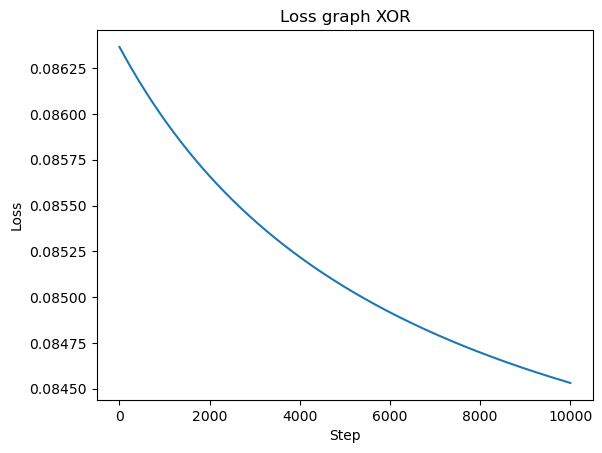

In [275]:
loss_list = []
for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)

    # 가중치 업데이트
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # --------------------------------------
                # 키 형식 확인
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
    
            # 인덱스 추출
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
            
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue

            # --------------------------------------
            
            # ex. key = w_11, w_12 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    # 편향 업데이트
    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1]) - 1 # 'b1'에서 1 추출
            # --------------------------------------
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue

            # --------------------------------------
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]

    # Loss값 저장
    loss_list.append(network.loss(X_data, y_data))

plt.plot(np.arange(len(loss_list)), loss_list)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Loss graph XOR")
plt.show()

### 각 은닉층의 노드 수 2개

In [279]:
network = Neural_Network(input_size=2,hidden_size=2,output_size=1)

print("초기화된 신경망의 파라미터값 :")
print(network.params)

print("\n가중치 연결 정보")
print(network.connection_keys)

초기화된 신경망의 파라미터값 :
{'W1': array([[-0.04327777, -0.64129676],
       [ 2.10821832,  1.01753057]]), 'b1': array([0., 0.]), 'W2': array([[-0.1658162 ],
       [ 0.55298837]]), 'b2': array([0.])}

가중치 연결 정보
{'W1': ['w1_1', 'w1_2', 'w2_1', 'w2_2'], 'b1': ['b1', 'b2'], 'W2': ['w1_1', 'w2_1'], 'b2': ['b1']}


In [281]:
lr = 0.1
epoch = 10001

for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)
    
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # # ex. key = w_1_1, w_1_2 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출

            # --------------------------------------
            
            # 'w1_100' → '1', '100' 추출
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
                 
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
        
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue
            # --------------------------------------
            
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1:]) - 1 # 'b100'에서 100 추출
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]
 
    if i % (epoch//10) == 0:
        print("=============================================================")
        print("\n{}th 업데이트".format(i))
        
        acc = network.accuracy(X_data, y_data)
        print("정확도 : ", acc)
        
        loss = network.loss(X_data, y_data)
        print("손실함수값 : ", loss)
        print("예측 : : \n", np.round(network.predict(X_data), 2))
        
        print("\n파라미터값 : \n", network.params)
        
        print("\n손실함수에 대한 각 파라미터의 미분값 : \n", grad)
        print("\n\n")


0th 업데이트
정확도 :  0.5
손실함수값 :  0.16105588243173571
예측 : : 
 [[0.24]
 [0.16]
 [0.32]
 [0.24]]

파라미터값 : 
 {'W1': array([[-0.04412522, -0.63911853],
       [ 2.10799624,  1.01892708]]), 'b1': array([-0.00094375,  0.00350878]), 'W2': array([[-0.14482329],
       [ 0.56918658]]), 'b2': array([0.03144293])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[ 0.00847452, -0.02178233],
       [ 0.0022208 , -0.01396506]]), 'b1': array([ 0.0094375 , -0.03508777]), 'W2': array([[-0.20992914],
       [-0.16198219]]), 'b2': array([-0.31442925])}




1000th 업데이트
정확도 :  0.75
손실함수값 :  0.12160311930488421
예측 : : 
 [[0.44]
 [0.51]
 [0.5 ]
 [0.54]]

파라미터값 : 
 {'W1': array([[-0.49140121, -0.60151066],
       [ 2.16325822,  0.8382796 ]]), 'b1': array([ 0.07303408, -0.29769863]), 'W2': array([[-0.38314205],
       [ 0.54143286]]), 'b2': array([0.50649621])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[ 0.00584014,  0.00136055],
       [-0.00121032, -0.00068855]]), 'b1': array([-0.00287659,  0.00352865]), 'W2': array([[ 0.

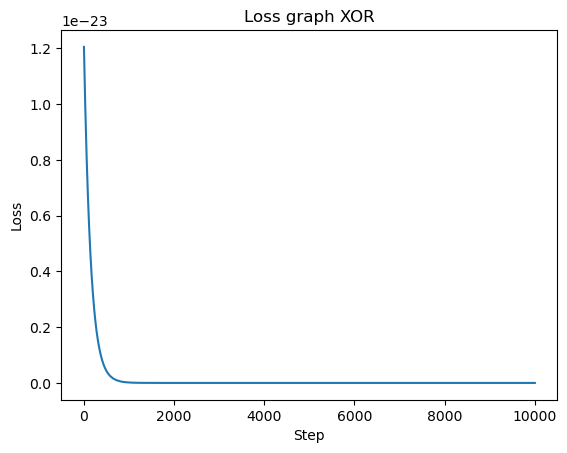

In [283]:
import matplotlib.pyplot as plt
 

loss_list = []
for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)

    # 가중치 업데이트
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # --------------------------------------
                # 키 형식 확인
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
    
            # 인덱스 추출
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
            
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue

            # --------------------------------------
            
            # ex. key = w_11, w_12 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    # 편향 업데이트
    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1]) - 1 # 'b1'에서 1 추출
            # --------------------------------------
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue

            # --------------------------------------
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]

    # Loss값 저장
    loss_list.append(network.loss(X_data, y_data))

plt.plot(np.arange(len(loss_list)), loss_list)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Loss graph XOR")
plt.show()

### 각 은닉층의 노드 수 5개

In [287]:
network = Neural_Network(input_size=2,hidden_size=5,output_size=1)

print("초기화된 신경망의 파라미터값 :")
print(network.params)

print("\n가중치 연결 정보")
print(network.connection_keys)

초기화된 신경망의 파라미터값 :
{'W1': array([[ 0.23302534,  0.18261967,  0.31432037, -0.36927982,  0.49316054],
       [-2.00335406, -0.04543188,  2.74241811, -0.52896242, -1.19878855]]), 'b1': array([0., 0., 0., 0., 0.]), 'W2': array([[1.05748785],
       [1.82903586],
       [0.86323669],
       [0.32259141],
       [0.67855265]]), 'b2': array([0.])}

가중치 연결 정보
{'W1': ['w1_1', 'w1_2', 'w1_3', 'w1_4', 'w1_5', 'w2_1', 'w2_2', 'w2_3', 'w2_4', 'w2_5'], 'b1': ['b1', 'b2', 'b3', 'b4', 'b5'], 'W2': ['w1_1', 'w2_1', 'w3_1', 'w4_1', 'w5_1'], 'b2': ['b1']}


In [289]:
lr = 0.1
epoch = 10001

for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)
    
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # # ex. key = w_1_1, w_1_2 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출

            # --------------------------------------
            
            # 'w1_100' → '1', '100' 추출
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
                 
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
        
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue
            # --------------------------------------
            
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1:]) - 1 # 'b100'에서 100 추출
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]
 
    if i % (epoch//10) == 0:
        print("=============================================================")
        print("\n{}th 업데이트".format(i))
        
        acc = network.accuracy(X_data, y_data)
        print("정확도 : ", acc)
        
        loss = network.loss(X_data, y_data)
        print("손실함수값 : ", loss)
        print("예측 : : \n", np.round(network.predict(X_data), 2))
        
        print("\n파라미터값 : \n", network.params)
        
        print("\n손실함수에 대한 각 파라미터의 미분값 : \n", grad)
        print("\n\n")


0th 업데이트
정확도 :  0.5
손실함수값 :  1.0536020253041416
예측 : : 
 [[1.76]
 [2.13]
 [1.63]
 [1.91]]

파라미터값 : 
 {'W1': array([[ 0.21486092,  0.13816531,  0.30358281, -0.37624605,  0.47807887],
       [-2.01389135, -0.08394624,  2.7389546 , -0.53481579, -1.21066539]]), 'b1': array([-0.03693007, -0.0842602 , -0.02491222, -0.01383888, -0.02849944]), 'W2': array([[0.99335992],
       [1.73309111],
       [0.72956834],
       [0.24943221],
       [0.59820734]]), 'b2': array([-0.18489314])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[0.18164413, 0.44454355, 0.10737559, 0.06966233, 0.15081666],
       [0.10537284, 0.38514358, 0.03463509, 0.0585337 , 0.11876846]]), 'b1': array([0.36930065, 0.842602  , 0.24912218, 0.13838881, 0.28499436]), 'W2': array([[0.64127931],
       [0.95944752],
       [1.3366835 ],
       [0.73159199],
       [0.80345313]]), 'b2': array([1.84893136])}




1000th 업데이트
정확도 :  1.0
손실함수값 :  0.058776198922228955
예측 : : 
 [[0.44]
 [0.73]
 [0.62]
 [0.24]]

파라미터값 : 
 {'W1': array([[ 0.8999

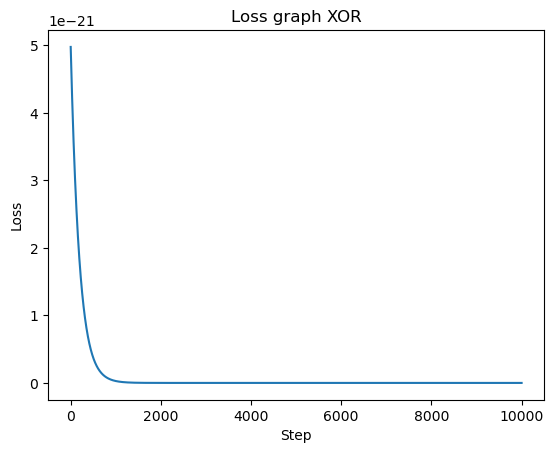

In [291]:
import matplotlib.pyplot as plt
 

loss_list = []
for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)

    # 가중치 업데이트
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # --------------------------------------
                # 키 형식 확인
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
    
            # 인덱스 추출
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
            
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue

            # --------------------------------------
            
            # ex. key = w_11, w_12 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    # 편향 업데이트
    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1]) - 1 # 'b1'에서 1 추출
            # --------------------------------------
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue

            # --------------------------------------
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]

    # Loss값 저장
    loss_list.append(network.loss(X_data, y_data))

plt.plot(np.arange(len(loss_list)), loss_list)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Loss graph XOR")
plt.show()

### 각 은닉층의 노드 수 10개

In [295]:
network = Neural_Network(input_size=2,hidden_size=10,output_size=1)

print("초기화된 신경망의 파라미터값 :")
print(network.params)

print("\n가중치 연결 정보")
print(network.connection_keys)

초기화된 신경망의 파라미터값 :
{'W1': array([[-1.73459147, -0.2067534 ,  1.04413804, -0.57742004,  0.33467612,
         1.24215539, -0.61231576, -0.98798269, -0.39140641,  0.58809654],
       [-1.58405223, -0.44733832, -0.58963515,  0.42075308,  0.99994301,
         1.00702368,  1.07341472,  0.52429337,  1.08794476,  0.69692343]]), 'b1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'W2': array([[ 0.52292255],
       [-0.10828196],
       [-1.03190644],
       [ 0.16816868],
       [-0.28852498],
       [ 0.77750969],
       [ 0.33565616],
       [-0.44274725],
       [ 0.43241218],
       [-0.24302056]]), 'b2': array([0.])}

가중치 연결 정보
{'W1': ['w1_1', 'w1_2', 'w1_3', 'w1_4', 'w1_5', 'w1_6', 'w1_7', 'w1_8', 'w1_9', 'w1_10', 'w2_1', 'w2_2', 'w2_3', 'w2_4', 'w2_5', 'w2_6', 'w2_7', 'w2_8', 'w2_9', 'w2_10'], 'b1': ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10'], 'W2': ['w1_1', 'w2_1', 'w3_1', 'w4_1', 'w5_1', 'w6_1', 'w7_1', 'w8_1', 'w9_1', 'w10_1'], 'b2': ['b1']}


In [297]:
lr = 0.1
epoch = 10001

for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)
    
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # # ex. key = w_1_1, w_1_2 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출

            # --------------------------------------
            
            # 'w1_100' → '1', '100' 추출
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
                 
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
        
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue
            # --------------------------------------
            
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1:]) - 1 # 'b100'에서 100 추출
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]
 
    if i % (epoch//10) == 0:
        print("=============================================================")
        print("\n{}th 업데이트".format(i))
        
        acc = network.accuracy(X_data, y_data)
        print("정확도 : ", acc)
        
        loss = network.loss(X_data, y_data)
        print("손실함수값 : ", loss)
        print("예측 : : \n", np.round(network.predict(X_data), 2))
        
        print("\n파라미터값 : \n", network.params)
        
        print("\n손실함수에 대한 각 파라미터의 미분값 : \n", grad)
        print("\n\n")


0th 업데이트
정확도 :  0.5
손실함수값 :  0.18478891616462667
예측 : : 
 [[ 0.24]
 [-0.04]
 [ 0.47]
 [ 0.23]]

파라미터값 : 
 {'W1': array([[-1.73257072, -0.20754978,  1.03828665, -0.57627445,  0.33257588,
         1.24622444, -0.61004953, -0.99056287, -0.38831324,  0.58642919],
       [-1.58272366, -0.44778547, -0.5937267 ,  0.42144819,  0.9989529 ,
         1.0097371 ,  1.07450371,  0.52250457,  1.08934284,  0.69597849]]), 'b1': array([ 0.00316532, -0.00122386, -0.00976692,  0.00181364, -0.00302253,
        0.00654528,  0.00329786, -0.00429326,  0.0044115 , -0.00255618]), 'W2': array([[ 0.52980736],
       [-0.08855352],
       [-1.00413062],
       [ 0.18896274],
       [-0.25888419],
       [ 0.81297146],
       [ 0.35864725],
       [-0.4241354 ],
       [ 0.45698875],
       [-0.21269527]]), 'b2': array([0.04632639])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[-0.02020745,  0.00796378,  0.05851388, -0.01145591,  0.02100244,
        -0.04069053, -0.02266232,  0.02580179, -0.03093171,  0.01667348],
   

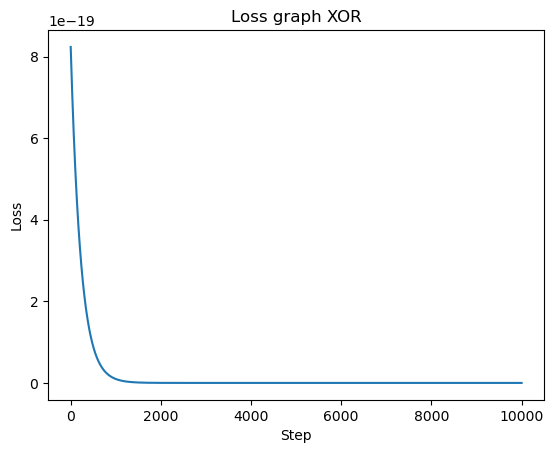

In [299]:
import matplotlib.pyplot as plt
 

loss_list = []
for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)

    # 가중치 업데이트
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # --------------------------------------
                # 키 형식 확인
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
    
            # 인덱스 추출
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
            
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue

            # --------------------------------------
            
            # ex. key = w_11, w_12 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    # 편향 업데이트
    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1]) - 1 # 'b1'에서 1 추출
            # --------------------------------------
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue

            # --------------------------------------
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]

    # Loss값 저장
    loss_list.append(network.loss(X_data, y_data))

plt.plot(np.arange(len(loss_list)), loss_list)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Loss graph XOR")
plt.show()

### 각 은닉층의 노드 수 100개

In [302]:
network = Neural_Network(input_size=2,hidden_size=100,output_size=1)

print("초기화된 신경망의 파라미터값 :")
print(network.params)

print("\n가중치 연결 정보")
print(network.connection_keys)

초기화된 신경망의 파라미터값 :
{'W1': array([[ 0.47166836, -0.10284783, -0.48921664, -2.96956043,  2.44478054,
        -1.05220305, -1.27719959, -1.54040154,  0.51235543,  0.12748217,
        -1.25266759,  0.14257616,  0.21641925,  0.84473945, -0.51188955,
         0.46864455, -0.29560294, -1.59964071,  0.5953789 ,  0.56675244,
         0.48944095,  0.97122446, -0.52650371, -0.53253607, -0.79585221,
        -0.91553825,  0.48566189,  0.64982686,  1.12765818,  0.26152754,
        -0.44801967, -1.1360859 ,  1.90088396,  0.36362256, -1.41524222,
        -0.36886266,  0.51965523,  1.03451972,  0.95996099,  0.39212598,
        -0.58640682,  1.24841217, -0.08556184, -0.43452417, -1.29740394,
         0.30997543,  0.38328437,  0.68654003,  1.22900465, -0.8224817 ,
         0.90449579, -0.50799604, -0.86158313, -1.18357194, -0.81168797,
        -1.81071197,  0.50390633, -1.35266576, -0.59333527,  0.00605884,
         1.35501122, -1.94858694, -0.55521034,  0.13929767, -0.43704863,
         2.56164589, -2.00

In [304]:
lr = 0.1
epoch = 10001

for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)
    
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # # ex. key = w_1_1, w_1_2 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출

            # --------------------------------------
            
            # 'w1_100' → '1', '100' 추출
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
                 
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
        
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue
            # --------------------------------------
            
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1:]) - 1 # 'b100'에서 100 추출
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]
 
    if i % (epoch//10) == 0:
        print("=============================================================")
        print("\n{}th 업데이트".format(i))
        
        acc = network.accuracy(X_data, y_data)
        print("정확도 : ", acc)
        
        loss = network.loss(X_data, y_data)
        print("손실함수값 : ", loss)
        print("예측 : : \n", np.round(network.predict(X_data), 2))
        
        print("\n파라미터값 : \n", network.params)
        
        print("\n손실함수에 대한 각 파라미터의 미분값 : \n", grad)
        print("\n\n")


0th 업데이트
정확도 :  0.25
손실함수값 :  5.109216422179321
예측 : : 
 [[ 0.68]
 [-3.32]
 [ 0.3 ]
 [-4.61]]

파라미터값 : 
 {'W1': array([[ 0.47767784, -0.10585907, -0.4943381 , -2.96770547,  2.43933847,
        -1.05157054, -1.27600309, -1.53269181,  0.51475763,  0.12846669,
        -1.24481713,  0.14087651,  0.21493428,  0.86053847, -0.49716673,
         0.47165362, -0.2939004 , -1.61348744,  0.61109548,  0.58426314,
         0.48371043,  0.96971377, -0.52177988, -0.55459057, -0.79192485,
        -0.90762554,  0.49265789,  0.64502702,  1.14177194,  0.27010281,
        -0.45632744, -1.14596052,  1.89263496,  0.36226215, -1.41004914,
        -0.37331238,  0.56401169,  1.05828812,  0.9796536 ,  0.38310448,
        -0.5611885 ,  1.24939196, -0.08392654, -0.44959332, -1.30410873,
         0.30050337,  0.39445977,  0.6768918 ,  1.23243946, -0.82109161,
         0.90068863, -0.50625706, -0.8513443 , -1.19892484, -0.81194294,
        -1.81069256,  0.53298611, -1.34935943, -0.587022  ,  0.00580544,
         1.

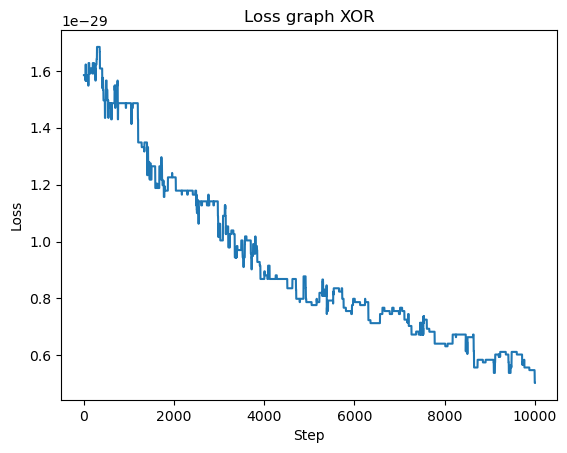

In [306]:
import matplotlib.pyplot as plt
 

loss_list = []
for i in range(epoch):
 
    grad = network.gradient(X_data,y_data)

    # 가중치 업데이트
    for layer_key in ['W1', 'W2']: # 층별로 반복
        for key in network.connection_keys[layer_key]: # 개별 연결 w_ij에 대해 반복

            # --------------------------------------
                # 키 형식 확인
            if "_" not in key:
                print(f"Skipping invalid key format: {key}")
                continue
    
            # 인덱스 추출
            i_idx, j_idx = map(lambda x: int(x) - 1, key[1:].split("_"))
            
            # 인덱스 범위 검사
            if i_idx >= network.params[layer_key].shape[0] or j_idx >= network.params[layer_key].shape[1]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}, j_idx: {j_idx}")
                continue

            # --------------------------------------
            
            # ex. key = w_11, w_12 ...
            # layer_idx = layer_key # 'W1', 'W2' 등
            # i_idx, j_idx = int(key[1]) -1, int(key[2]) - 1 # 'w_11'에서 1, 1 추출
            network.params[layer_key][i_idx, j_idx] -= lr * grad[layer_key][i_idx, j_idx]

    # 편향 업데이트
    for layer_key in ['b1', 'b2']:
        for key in network.connection_keys[layer_key]:
            i_idx = int(key[1]) - 1 # 'b1'에서 1 추출
            # --------------------------------------
            if i_idx >= network.params[layer_key].shape[0]:
                print(f"Skipping invalid index for key: {key}, i_idx: {i_idx}")
                continue

            # --------------------------------------
            network.params[layer_key][i_idx] -= lr * grad[layer_key][i_idx]

    # Loss값 저장
    loss_list.append(network.loss(X_data, y_data))

plt.plot(np.arange(len(loss_list)), loss_list)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Loss graph XOR")
plt.show()

### loss가 임계값보다 작아지면 주어진 epoch보다 빠르게 학습 종료

Epoch 0, Loss: 0.175980, Accuracy: 0.50
Epoch 1000, Loss: 0.042883, Accuracy: 1.00
Epoch 2000, Loss: 0.000330, Accuracy: 1.00
Early Stopping at epoch 2590, Loss: 9.972215707402832e-06, Accuracy: 1.00


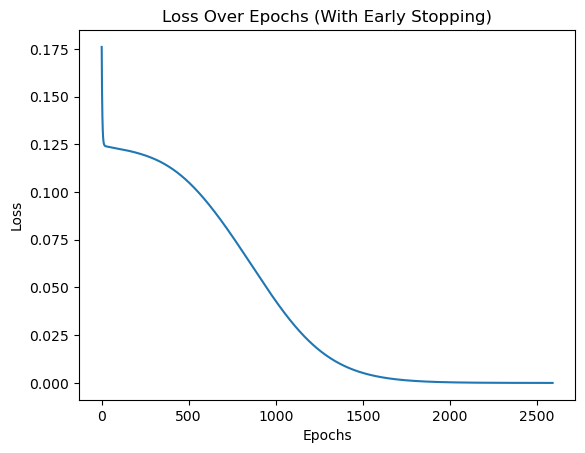

In [31]:
# Initialize network
network = Neural_Network(input_size=2, hidden_size=2, output_size=1)

# Training with Early Stopping
lr = 0.1
epoch = 10001
early_stopping_threshold = 1e-5
loss_list = []

for i in range(epoch):
    grads = network.gradient(X_data, y_data)

    for key in network.params:
        network.params[key] -= lr * grads[key]

    loss = network.loss(X_data, y_data)
    loss_list.append(loss)

    if loss < early_stopping_threshold:
        print(f"Early Stopping at epoch {i}, Loss: {loss}, Accuracy: {network.accuracy(X_data, y_data):.2f}")
        break

    if i % 1000 == 0:
        print(f"Epoch {i}, Loss: {loss:.6f}, Accuracy: {network.accuracy(X_data, y_data):.2f}")

# Plot Loss
plt.plot(loss_list)
plt.title("Loss Over Epochs (With Early Stopping)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Early Stopping for hidden_size 2 at epoch 7088, Loss: 9.984553143827138e-07
Early Stopping for hidden_size 5 at epoch 4133, Loss: 9.992193217600734e-07
Early Stopping for hidden_size 10 at epoch 2159, Loss: 9.928898982399092e-07
Early Stopping for hidden_size 100 at epoch 1979, Loss: 9.993642039347527e-07


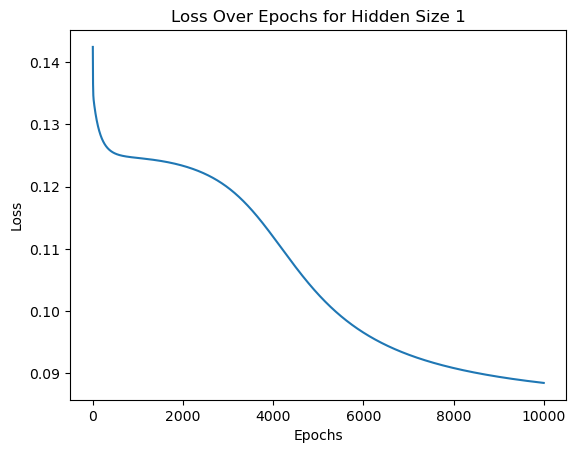

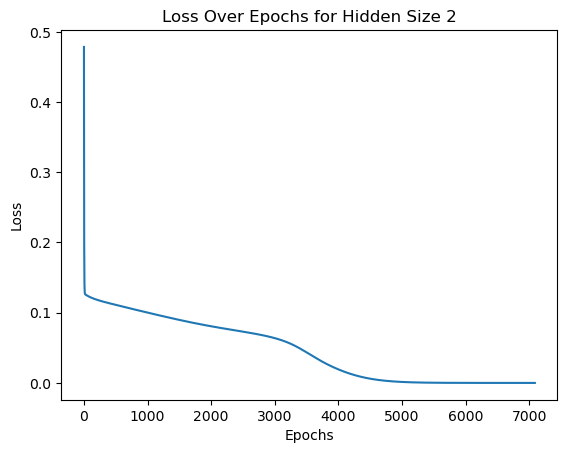

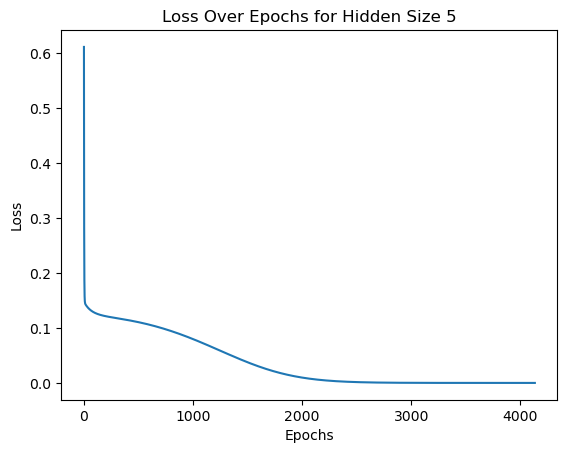

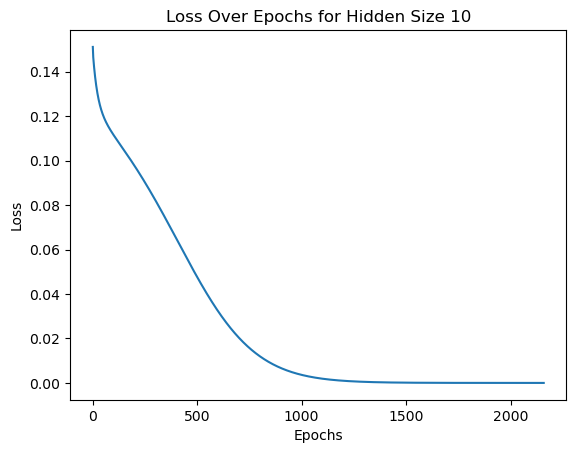

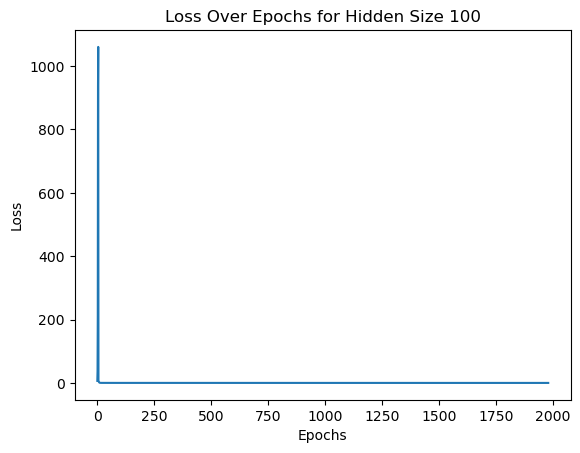

In [51]:
hidden_sizes = [1, 2, 5, 10, 100]
results = []

# Training and evaluation for each hidden size
for hidden_size in hidden_sizes:
    network = Neural_Network(input_size=2, hidden_size=hidden_size, output_size=1)
    lr = 0.1
    epoch = 10001
    early_stopping_threshold = 1e-6
    loss_list = []

    for i in range(epoch):
        grads = network.gradient(X_data, y_data)
        for key in network.params:
            network.params[key] -= lr * grads[key]

        loss = network.loss(X_data, y_data)
        loss_list.append(loss)

        if loss < early_stopping_threshold:
            print(f"Early Stopping for hidden_size {hidden_size} at epoch {i}, Loss: {loss}")
            break

    accuracy = network.accuracy(X_data, y_data)
    results.append((hidden_size, loss_list, accuracy))

# Plotting individual graphs for each hidden size
for hidden_size, loss_list, accuracy in results:
    plt.figure()
    plt.plot(loss_list)
    plt.title(f"Loss Over Epochs for Hidden Size {hidden_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [52]:
# Displaying final accuracies
import pandas as pd
df_results = pd.DataFrame({
    "Hidden Size": [res[0] for res in results],
    "Final Loss": [res[1][-1] for res in results],
    "Accuracy": [res[2] for res in results],
    "Epoch": [len(res[1]) for res in results]
})

df_results

,Hidden Size,Final Loss,Accuracy,Epoch
0,1,8.847234e-02,0.75,10001
1,2,9.984553e-07,1.00,7089
2,5,9.992193e-07,1.00,4134
3,10,9.928899e-07,1.00,2160
4,100,9.993642e-07,1.00,1980
